<div>
<img src="svtLogo.png"/>
</div>

<h1><center>Mathematical Optimization for Engineers</center></h1>
<h2><center>Lab 11 - Full discretization method</center></h2>

In this exercise, we want to solve the van der Pol oscillator optimal control problem using the full discretization approach. 
The problem with state constraint is as follows: 
$\begin{align}
\min_{u(t)} \int_{t_{0}}^{t_{f}} x_1^2(t) &+ x_2^{2}(t) + u(t)^2 dt\\
s.t.  \dot{x} &= f(x(t),u(t))\\
x(t_{0}) &= x_{0} \\
x_1(t) &\geq - 0.4 \quad \forall t \in [t_{0},t_{f}]\\
-0.3 &\leq u(t) \leq 1.0\\
\end{align}
$

For the full discretization appraoch, the differential equations are discretized usually by implicit Runge-Kutta methods. In this exercise, we will use the implicit Euler method due to its simplicity.


### Imports

In [1]:
import numpy as np

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint

from matplotlib import pyplot as plt

### Right-hand side function of ODE

In [2]:
def eval_rhs(x, u):

    f = np.zeros(3)
    
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    
    f[0] = (1-x2**2)*x1 - x2 + u
    f[1] = x1
    f[2] = x1**2 + x2**2 + u**2
    
    return f

### Constraints for optimization - discretized ODE

In [36]:
def cons(y, x0, finalTime, M, n_u):
    h = finalTime/M
    n_x = len(x0)
    ceq = np.zeros(n_x*M)

    # backward Euler y_(k+1) = y_(k) + h.f(t_(k+1),y_(k+1))
    
    f1 = eval_rhs(y[0:n_x], y[n_x:n_x+n_u]) # first time step
    
    ceq[0:n_x] = x0 + h*f1 - y[0:n_x]
        
    # int(z) for z in [] just converts all elements in the list to integer
    # it's an implementation detail because python only allows integer indices
    
    # second time step onward
    for i in np.arange(2, M+1):  
        ic0 = (i-1) * n_x
        ic1 = [int(z) for z in range(ic0, ic0 + n_x)] # indices in ceq: current time step
        
        ix0 = (i-1) * (n_x + n_u)
        ix1 = [int(z) for z in range(ix0, ix0 + n_x)] #[ix0, ix0 + 1, ix0 + 2]] # indices in y: current time step
        ix = [int(z) for z in range(ix0-n_x-n_u, ix0-n_u)] # [ix0 - 4, ix0 - 3, ix0 - 2]] # indices in y: previous time step
        iu1 = int(ix0 + n_x)
        
        f1 = eval_rhs(y[ix1],y[iu1])
        
        ceq[ic1] = y[ix] + h*f1 - y[ix1]
            
    return ceq


### objective

In [40]:
def objective(y, x0):
    obj = y[-2]
    return obj

### Setting up optimization problem and solve it

In [41]:
n_x = 3 # dimension of state vector x 
n_u = 1 # dimension of control vector u

M=50 # Number of discretization intervals

x1_0 = 0 # initial value of x1
x2_0 = 1 # initial value of x2
x3_0 = 0 # initial value of x3

x_initial = [0.0, 1.0, 0.0]
finalTime = 5 # final time

x1_min = -0.4 # lower bound on x1
u_min = -0.3 # lower bound on u
u_max = 1.0 # upper bound on u


n = (n_x+n_u)*M # number of optimization variables
iu = (np.arange(3,n,4)).astype(int) # indices of control variables
ix1 = [int(z)-3 for z in iu] # indices of state x1
ix2 = [int(z)-2 for z in iu] # indices of state x2
ix3 = [int(z)-1 for z in iu] # indices of state x3

lb = -float("inf")*np.ones(n) # initialize lower bounds on all variables
ub = float("inf")*np.ones(n) # initialize upper bounds on all variables

lb[iu] = u_min*np.ones(M) # lower bound of control 
ub[iu] = u_max # upper bound of control
lb[ix1] = x1_min*np.ones(M) # lower bound on x1



x_guess = np.zeros(n)  # initial guess of optimzation variable

x_guess[ix1] = x1_0  # initial guess for state x1
x_guess[ix2] = x2_0  # initial guess for state x2
x_guess[ix3] = x3_0  # initial guess for state x3

x_guess[iu] = 0.0  # initial guess for control u

bounds = Bounds(lb, ub)

consWithInitial = lambda y: cons(y, x_initial, finalTime, M, n_u)

nonlinear_constraints = NonlinearConstraint(consWithInitial, 0, 0)
# trust-constr
res = minimize(objective, x_guess, args = (x_initial), method='SLSQP',
               constraints=[nonlinear_constraints],
               options={"maxiter": 10000, 'iprint': 2, 'disp': True}, bounds=bounds)

print('Optimal function value is')
print(res.fun)

  NIT    FC           OBJFUN            GNORM
    1   202    -1.108719E-01     1.000000E+00
    2   403     6.320982E-01     1.000000E+00
    3   604     2.714853E+00     1.000000E+00
    4   805     2.981548E+00     1.000000E+00
    5  1006     2.955657E+00     1.000000E+00
    6  1207     2.820939E+00     1.000000E+00
    7  1408     2.771703E+00     1.000000E+00
    8  1609     2.800691E+00     1.000000E+00
    9  1810     2.768467E+00     1.000000E+00
   10  2011     2.758840E+00     1.000000E+00
   11  2212     2.764718E+00     1.000000E+00
   12  2413     2.759293E+00     1.000000E+00
   13  2614     2.755296E+00     1.000000E+00
   14  2815     2.756104E+00     1.000000E+00
   15  3016     2.755835E+00     1.000000E+00
   16  3217     2.755881E+00     1.000000E+00
   17  3418     2.755706E+00     1.000000E+00
   18  3619     2.755752E+00     1.000000E+00
   19  3820     2.755763E+00     1.000000E+00
   20  4021     2.755764E+00     1.000000E+00
   21  4221     2.755764E+00     1

### Plot trajectories

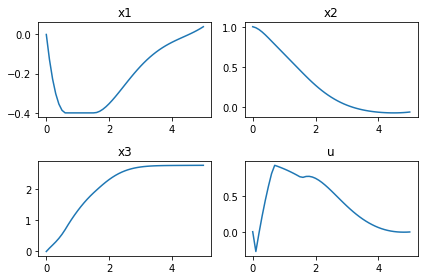

In [6]:
xopt = res.x

t = np.linspace(0, finalTime, M+1)
x1 = np.append([x1_0],list(xopt[np.arange(0,len(xopt),4)]))
x2 = np.append([x2_0],list(xopt[np.arange(1,len(xopt),4)]))
x3 = np.append([x3_0],list(xopt[np.arange(2,len(xopt),4)]))
u = np.append([0.0],list(xopt[np.arange(3,len(xopt),4)]))

plt.figure()
ax1 = plt.axes(xlim=(-4,4), ylim=(-4, 4))
plt.subplot(311)

plt.subplot(221)
plt.plot(t, x1)
plt.title('x1')

plt.subplot(222)
plt.plot(t, x2)
plt.title('x2')

plt.subplot(223)
plt.plot(t, x3)
plt.title('x3')
#
plt.subplot(224)
plt.plot(t, u)
plt.title('u')

plt.tight_layout()

plt.show()
